In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test  = np.reshape(x_test,  (-1, 28, 28, 1))
print("Train shape:", x_train.shape, "Test shape:", x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape: (60000, 28, 28, 1) Test shape: (10000, 28, 28, 1)


In [2]:
latent_dim = 64

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 784)       │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     16,448 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     16,448 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 64)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 233,856 (913.50 KB)

 Trainable params: 233,856 (913.50 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(28*28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28,28,1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 784)            │       201,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,128 (852.06 KB)

 Trainable params: 218,128 (852.06 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        recon = self.decoder(z)

        recon_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(
                tf.reshape(inputs, (-1, 28*28)),
                tf.reshape(recon,  (-1, 28*28))
            )
        )

        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        self.add_loss(recon_loss + kl_loss)
        return recon

In [6]:
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(x_train, x_train, epochs=5, batch_size=128, validation_data=(x_test, x_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.3319 - val_loss: 0.2636
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2631 - val_loss: 0.2614
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.2609 - val_loss: 0.2597
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.2601 - val_loss: 0.2590
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2592 - val_loss: 0.2587


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


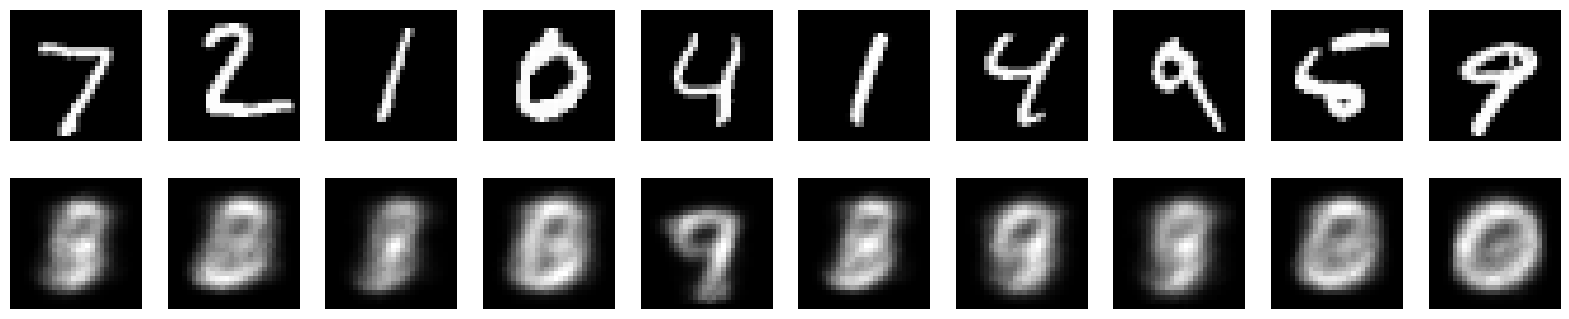

In [7]:
decoded_imgs = vae.predict(x_test[:10])

plt.figure(figsize=(20, 4))
for i in range(10):

    ax = plt.subplot(2, 10, i+1)
    plt.imshow(x_test[i].squeeze(), cmap="gray")
    plt.axis("off")

    ax = plt.subplot(2, 10, 10+i+1)
    plt.imshow(decoded_imgs[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()